In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import seaborn as sns
import pandas as pd

In [3]:
def rescale_image(image, label):
    '''
    Rescale the pixel values of an image to the range [0, 1].

    Parameters:
        image (tf.Tensor): The input image as a TensorFlow Tensor.
        label (tf.Tensor): The label corresponding to the image.

    Returns:
        tf.Tensor: The rescaled image with pixel values in the range [0, 1]
        tf.Tensor: The original label.

    Note:
      The input dataset is expected to contain tuples of (image, label).
    '''

    rescale_factor = 1./ 255.0
    image = tf.cast(image, tf.float32)

    image = image * rescale_factor
    return image, label

In [4]:
def load(path):
    dataset = tf.keras.utils.image_dataset_from_directory(
           directory = path,
           label_mode = 'int',
           batch_size = 1,
           image_size = (128,128),
           shuffle = False)
    dataset = dataset.map(rescale_image)
    return dataset

def load_data(images_path, cancer_names):
    """
    Load image datasets for cancer detection and image origin prediction.

    This function loads image datasets for each specified cancer type and the image origin prediction.

    Args:
        images_path (str): Path to the directory containing subdirectories of images.
        cancer_names (list): List of cancer type names.

    Returns:
        tuple: A tuple containing two elements:
            - A dictionary of cancer image datasets where keys are cancer type names and values are datasets.
            - The image origin prediction dataset.
    """
    cancer_datasets = {}
    
    for i, class_name in enumerate(cancer_names):
        if class_name not in cancer_names:
            continue
        
        class_path = os.path.join(images_path, cancer_names[i],"test")  
        cancer_datasets[cancer_names[i]] = load(class_path)
        
    IOM_dataset = load(images_path)
    return cancer_datasets, IOM_dataset

In [5]:
def get_y(cancer_datasets, IOM_dataset):
    """
    Generate target labels for cancer types and the main dataset.

    Args:
        cancer_datasets (dict): A dictionary containing cancer types as keys and corresponding datasets as values.
                     Each dataset should be an iterable where each element is a tuple (sample, label).
        IOM_dataset (iterable): The image origin dataset containing tuples (sample, label).

    Returns:
        tuple: A tuple containing two elements:
               - y_cancer (dict): A dictionary with cancer types as keys and NumPy arrays of ground truth labels as values.
               - y_IOM (ndarray): A NumPy array of ground truth labels for the main dataset.
    """
    
    y_cancer = {cancer_type: np.array([int(label.numpy()[0]) for _, label in dataset]) for cancer_type, dataset in cancer_datasets.items()}
    y_IOM = np.array([label.numpy()[0] for _, label in IOM_dataset])
    
    return y_cancer, y_IOM

In [6]:
def load_models(cancer_models_path, IOM_model_path):
    """
    Load deep learning models for cancer detection and image origin prediction.

    This function loads multiple cancer detection models and an image origin model
    from the specified paths.

    Args:
        cancer_models_path (dict): A dictionary containing model names as keys and their respective
                                  file paths as values for cancer detection models.
        IOM_model_path (str): File path for the image origin model.

    Returns:
        tuple: A tuple containing two elements:
            - A dictionary of cancer detection models where keys are model names and values are
              the loaded model instances.
            - The loaded image origin model.
    """
    cancer_models = {
        name: load_model(path) for name, path in cancer_models_path.items()
    }
    IOM_model = load_model(IOM_model_path)
    return cancer_models, IOM_model

In [7]:
def predict(dataset, model):
    """
    Get predictions for a dataset.

    Args:
        dataset (iterable): The dataset.
        model (trained model): The trained model.

    Returns:
        predictions (ndarray): The predictions.
    """
    prediction = model.predict(dataset)
    if prediction.shape[1] == 1:
        return (prediction > 0.5).astype(int).reshape(-1,)
    else:
        return np.argmax(prediction, axis=1)

def get_predictions(cancer_datasets, IOM_dataset, cancer_models, IOM_model):
    """
    Get predictions for cancer datasets and main dataset.

    Args:
        cancer_datasets (dict): A dictionary of cancer datasets, where the keys are the cancer types and the values are the NumPy arrays of the datasets.
        IOM_dataset (NumPy array): The image origin dataset.
        cancer_models (dict): A dictionary of cancer models, where the keys are the cancer types and the values are the trained models.
        IOM_model (trained model): The image origin model.

    Returns:
        cancer_predictions (dict): A dictionary of cancer predictions, where the keys are the cancer types and the values are the NumPy arrays of the predictions.
        IOM_predictions (NumPy array): The image origin predictions.
    """
    cancer_predictions = {
        cancer_type: predict(dataset, cancer_models[cancer_type])
        for cancer_type, dataset in cancer_datasets.items()
    }
    
    IOM_predictions = predict(IOM_dataset, IOM_model)

    return cancer_predictions, IOM_predictions

In [45]:
def joint_accuracy(y_cancer, y_IOM, cancer_predictions, IOM_predictions):
    """
    Calculate the joint accuracy of cancer detection and image origin prediction.

    This function calculates the joint accuracy of cancer detection and image origin
    prediction based on the provided true labels and predictions.

    Args:
        y_cancer (dict): A dictionary containing true cancer labels for each cancer type.
        y_IOM (ndarray): True labels for image origin prediction.
        cancer_predictions (dict): A dictionary containing predicted cancer labels for each cancer type.
        IOM_predictions (ndarray): Predicted labels for image origin prediction.

    Returns:
        float: The joint accuracy score.
    """
    flat_cancer_predictions = np.array([label for cancer_type in cancer_predictions.values() for label in cancer_type])
    flat_y_cancer = np.array([label for cancer_type in y_cancer.values() for label in cancer_type])
    
    cancer_correct = flat_cancer_predictions == flat_y_cancer
    IOM_correct = IOM_predictions == y_IOM
    
    joint_correct = np.logical_and(cancer_correct, IOM_correct)
    joint_accuracy = np.sum(joint_correct) / len(y_IOM)
    
    return f"The joint accuracy for the system is :{joint_accuracy}"

In [43]:
def plot_accuracy(y_cancer, cancer_predictions):
    """
    Plot the accuracy of cancer prediction models.

    Args:
        y_cancer (dict): A dictionary containing true cancer labels for each cancer type.
        y_IOM (ndarray): True labels for image origin prediction.
        cancer_predictions (dict): A dictionary containing predicted cancer labels for each cancer type.
        IOM_predictions (ndarray): Predicted labels for image origin prediction.

    This function calculates the accuracy for each cancer prediction model based on true and predicted values
    and plots a bar chart to visualize the accuracy scores.

    The input dictionaries should have the following format:
    Keys: Model names (e.g., 'model1', 'model2').
    Values: Lists of true or predicted values corresponding to each model.

    The bar chart includes error bars and value annotations for accuracy scores.

    Returns:
        None
    """
    accuracy_scores = {}
    for model, true_values in y_cancer.items():
        pred_values = cancer_predictions[model]
        correct_predictions = sum(1 for t, p in zip(true_values, pred_values) if t == p)
        accuracy = correct_predictions / len(true_values)
        accuracy_scores[model] = accuracy
    accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])

    plt.figure(figsize=(14, 14))
    sns.set_style("whitegrid")
    ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')
    plt.title('Model Accuracy')
    plt.ylim(0, 1) 
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45) 

    for i, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()# Adjust the vertical position of the annotation
        ax.annotate(f'{accuracy_df["Accuracy"][i]:.2f}', (x, y), ha='center')

    plt.tight_layout()
    plt.show()

In [9]:
images_path = '/kaggle/input/test-dataset'
cancer_models_path = {
    'Brain':'/kaggle/input/new-weights/Brain.h5',
    'Breast':'/kaggle/input/new-weights/Breast.h5',
    'Cervical': "/kaggle/input/new-weights/Cervical.h5",
    'Colon': "/kaggle/input/new-weights/Colon.h5",
    'Lung': "/kaggle/input/new-weights/Lung.h5",
    'Lymphoma':'/kaggle/input/new-weights/Lymphoma.h5',
    'Oral':'/kaggle/input/new-weights/Oral.h5',
}

cancer_names = list(cancer_models_path.keys())
IOM_model_path = "/kaggle/input/new-weights/Main.h5"

In [10]:
cancer_datasets, IOM_dataset = load_data(images_path, cancer_names)
y_cancer, y_IOM = get_y(cancer_datasets, IOM_dataset)

Found 2250 files belonging to 3 classes.
Found 1500 files belonging to 2 classes.
Found 3750 files belonging to 5 classes.
Found 1801 files belonging to 2 classes.
Found 2668 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.
Found 1502 files belonging to 2 classes.
Found 15721 files belonging to 7 classes.


In [11]:
cancer_models, IOM_model = load_models(cancer_models_path, IOM_model_path)

In [12]:
cancer_predictions, IOM_predictions = get_predictions(cancer_datasets,IOM_dataset,cancer_models,IOM_model)

15721/15721 [==============================] - 1011s 64ms/step


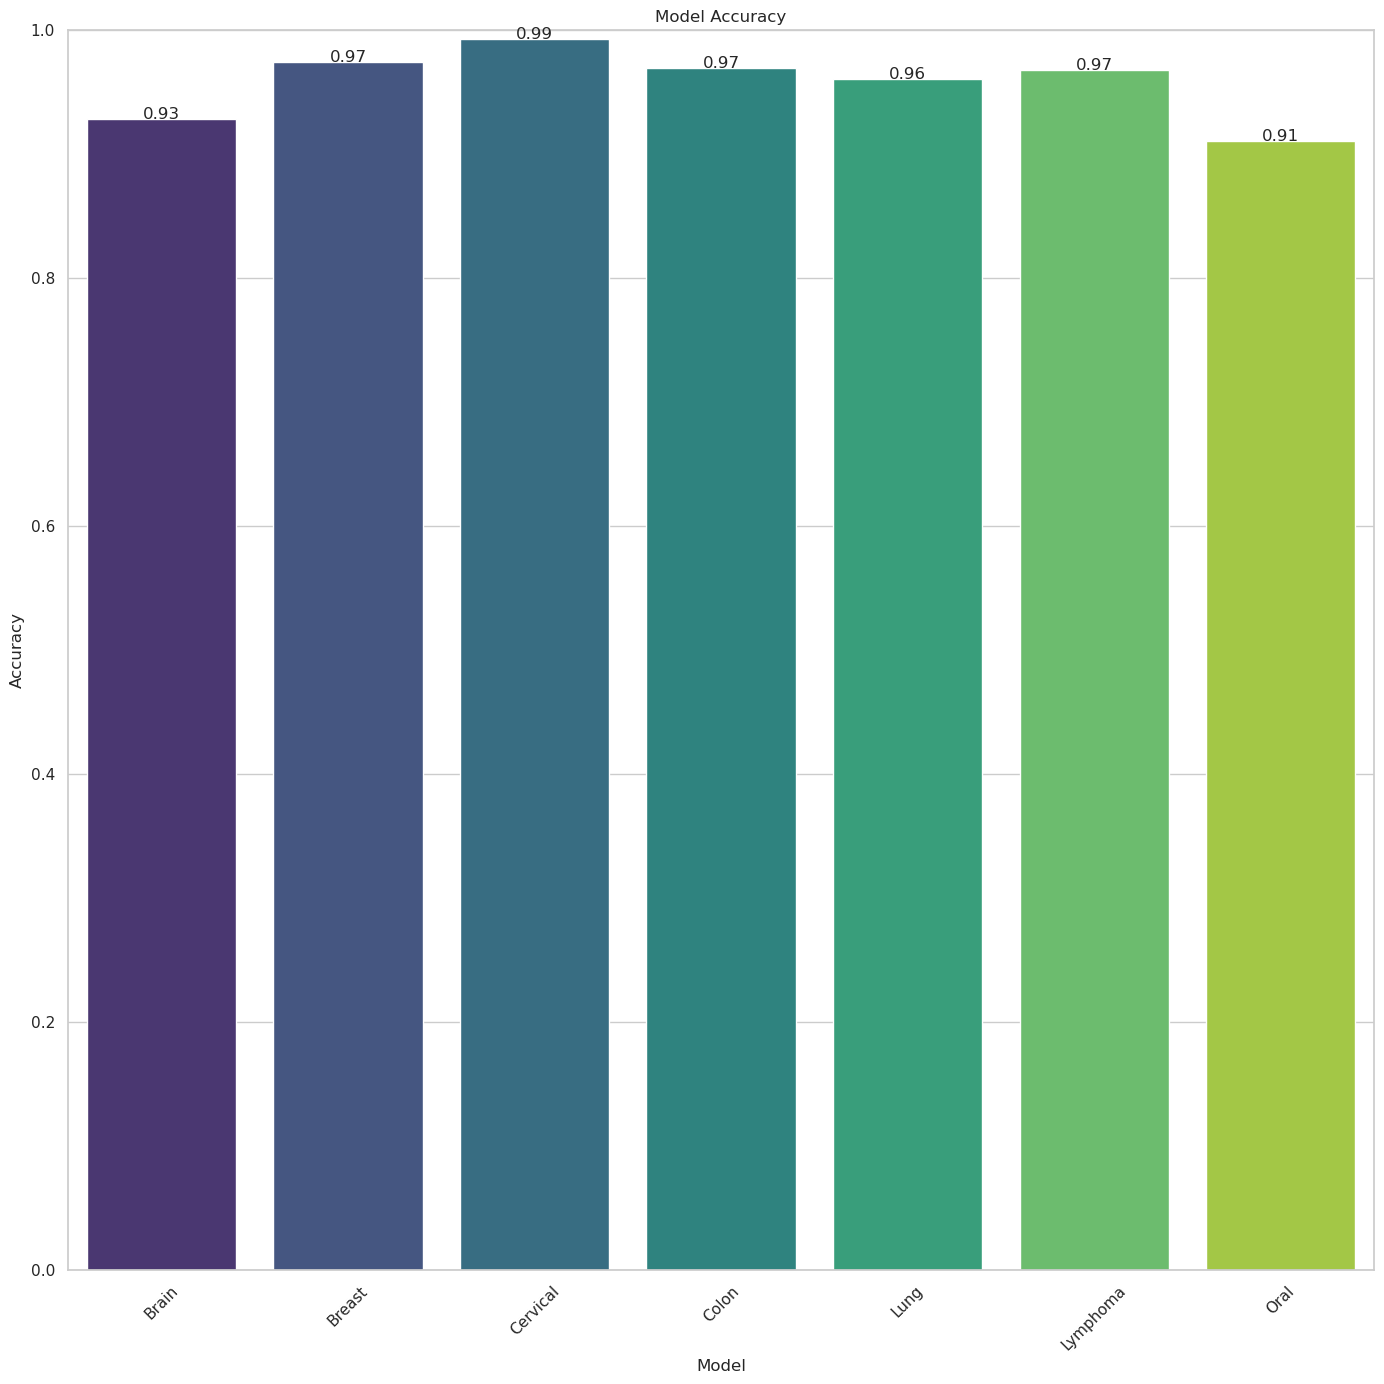

In [46]:
plot_accuracy(y_cancer, cancer_predictions)

In [47]:
joint_accuracy(y_cancer, y_IOM, cancer_predictions, IOM_predictions)

'The joint accuracy for the system is :0.9574454551237198'